# Task 3

In [1]:
from __future__ import print_function, division

#general operations
import time
import os
import copy

#for openning images via an URL
from PIL import Image
import requests

#data processing
import pandas as pd
import numpy as np

#data visualisation
import matplotlib.pyplot as plt

#ML tools
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data.dataset import Dataset
import torchvision
from torchvision import models, transforms

In [2]:
#! pip install scikit-image

In [3]:
from skimage import io

In [4]:
import pathlib

## Data Cleaning and Structuring

In [5]:
labelsArr=[]
imagesArr=[]

motherfolder='gear_images'

for label in os.listdir(motherfolder):
    for image in os.listdir(os.path.join(motherfolder,label)):
        labelsArr.append(label)
        imagesArr.append(os.path.join(motherfolder,label,image))
        
to_dict={'image_path': imagesArr, 'labels': labelsArr}

In [6]:
df=pd.DataFrame(to_dict)
df.head()

,image_path,labels
0,gear_images/axes/10260983_zm.jpeg,axes
1,gear_images/axes/10353612_zm.jpeg,axes
2,gear_images/axes/809257.jpeg,axes
3,gear_images/axes/850849.jpeg,axes
4,gear_images/axes/751753.jpeg,axes


In [7]:
mapping = enumerate(df.labels.unique())
reverse_mapping=dict(mapping)
forward_mapping={value: key for key,value in reverse_mapping.items()}

df['labels']=df['labels'].map(forward_mapping)

In [8]:
reverse_mapping

{0: 'axes',
 1: 'rope',
 2: 'harnesses',
 3: 'gloves',
 4: 'crampons',
 5: 'hardshell_jackets',
 6: 'insulated_jackets',
 7: 'boots',
 8: 'tents',
 9: 'carabiners',
 10: 'helmets',
 11: 'pulleys'}

In [9]:
df=df.reindex(np.random.permutation(df.index))

In [10]:
def func(x):
    item=pathlib.Path(x)
    return not item.exists()

In [11]:
func(df.image_path[0])

False

In [12]:
df[df['image_path'].apply(func)]

,image_path,labels


In [13]:
trainsize=int(df.shape[0]*0.9)
valsize=int((df.shape[0]-trainsize)/2)
testsize=df.shape[0]-trainsize-valsize

classes_num=len(df['labels'].unique())

In [14]:
train=df.iloc[:trainsize]
val=df.iloc[trainsize:(trainsize+valsize)]
test=df.iloc[-testsize:]

df_data={
    'train': train,
    'val':val,
    'test':test
        }

In [15]:
df_data['train'].iloc[:,1].head()

1606    8
1634    8
1292    6
985     5
419     2
Name: labels, dtype: int64

## Create Dataset Object

In [16]:
#creating our own customised data
class productData(Dataset):
    def __init__(self, raw_data, transforms=None):
        self.raw_data = raw_data
        self.transforms = transforms
        self.labels_arr = self.raw_data.iloc[:,1]
        self.image_arr = self.raw_data.iloc[:,0]
        self.data_len = len(self.raw_data.index)
        
    
    def __getitem__(self, index):
        one_img = Image.open(self.image_arr.iloc[index]).convert('RGB')
        
        if self.transforms is not None:
            transformed_img = self.transforms(one_img)
        else:
            transformations = transforms.Compose([transforms.ToTensor()])
            transformed_img = transformations(one_img)
        
        # Get the image Label
        single_image_label = self.labels_arr.iloc[index]
        
        return (transformed_img, single_image_label)
    
    def __len__(self):
        return self.data_len

In [18]:
#setting up the image transformation
transformations = transforms.Compose([
    transforms.Resize((224,224)),
    #transforms.Resize((32,32)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [19]:
keys=['train','val','test']
product_datasets = {key: productData(df_data[key], transforms=transformations) for key in keys}

datasets_loader = {key: torch.utils.data.DataLoader(dataset=product_datasets[key],
                                                batch_size=4,
                                                shuffle=False) for key in keys}

dataset_sizes = {key: len(product_datasets[key].labels_arr) for key in keys}

In [20]:
product_datasets['train'].image_arr.iloc[0]

'gear_images/tents/2030140_004_main.jpg'

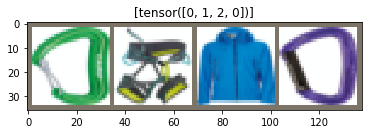

In [19]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(datasets_loader['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[classes])

In [20]:
print(inputs.size())

torch.Size([4, 3, 32, 32])


## Defining Model and Training Procedure

In [21]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    train_record=[]
    val_record=[]
    

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in datasets_loader[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            if phase == 'train':
                train_record.append([epoch_loss,epoch_acc])
            else:
                val_record.append([epoch_loss,epoch_acc])

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
            print('\n')

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_record, val_record

In [22]:
import torch.nn.functional as F

In [23]:
class OpenhackNN(nn.Module):
    def __init__(self):
        super(OpenhackNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(8 * 8 * 16, 60)
        self.fc2 = nn.Linear(60, 12)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [23]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [25]:
model_ft = OpenhackNN()

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [40]:
model_ft, t_record, v_record = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=12)

Epoch 0/11
----------
train Loss: 1.2980 Acc: 0.5495


val Loss: 1.1036 Acc: 0.6132


Epoch 1/11
----------
train Loss: 0.8060 Acc: 0.6998


val Loss: 0.8376 Acc: 0.6887


Epoch 2/11
----------
train Loss: 0.6751 Acc: 0.7658


val Loss: 0.6539 Acc: 0.7925


Epoch 3/11
----------
train Loss: 0.5728 Acc: 0.7878


val Loss: 0.6076 Acc: 0.8302


Epoch 4/11
----------
train Loss: 0.4970 Acc: 0.8057


val Loss: 0.6004 Acc: 0.8585


Epoch 5/11
----------
train Loss: 0.3645 Acc: 0.8649


val Loss: 0.4998 Acc: 0.8868


Epoch 6/11
----------
train Loss: 0.3531 Acc: 0.8680


val Loss: 0.5383 Acc: 0.8679


Epoch 7/11
----------
train Loss: 0.3512 Acc: 0.8701


val Loss: 0.5149 Acc: 0.8585


Epoch 8/11
----------
train Loss: 0.3390 Acc: 0.8706


val Loss: 0.4695 Acc: 0.8868


Epoch 9/11
----------
train Loss: 0.3199 Acc: 0.8701


val Loss: 0.5035 Acc: 0.8679


Epoch 10/11
----------
train Loss: 0.3152 Acc: 0.8821


val Loss: 0.4986 Acc: 0.8679


Epoch 11/11
----------
train Loss: 0.3173 Acc: 0.8816

## Model Evaluation

In [28]:
import matplotlib.pyplot as plt
def plot_graph(t, v, gtype='loss'):
    
    if gtype != 'loss':
        ind = 1
        gtype = 'accuracy'
    else:
        ind = 0
        
    periods=len(t_record)
    x=np.arange(0,periods)
    
    train=[x[ind] for x in t]
    val=[x[ind] for x in v]
    
    plt.plot(x,train)
    plt.plot(x,val)
    
    plt.legend(['train','val'])
    plt.title('{}: Train vs Validation'.format(gtype))
    plt.ylabel(gtype)
    plt.xlabel('Epoch')

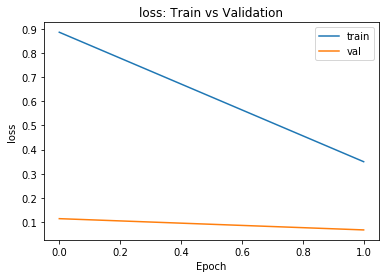

In [52]:
plot_graph(t_record, v_record)

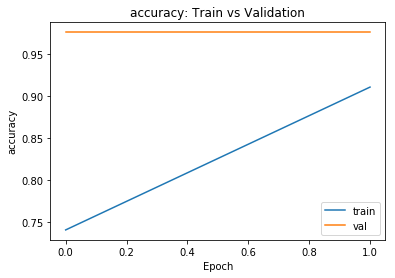

In [53]:
plot_graph(t_record, v_record, gtype='accuracy')

In [54]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(datasets_loader['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(reverse_mapping[int(preds[j])]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [55]:
visualize_model(model_ft)

NameError: name 'model_ft' is not defined

In [70]:
def visualise_online_model(model):
    num_images=len(test_set)
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, inputs in enumerate(testset_loader):
            inputs = inputs.to(device)
            #labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(reverse_mapping[int(preds[j])]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [78]:
test_images_online=[
    'http://images.the-house.com/head-sensor-ski-helmet-blk-16.jpg',
    'http://demandware.edgesuite.net/aakn_prd/on/demandware.static/-/Sites-bdel/default/dw8b3f6b64/products/carabiners_draws/S16/210074_Mini_Pearbiner_Screwgate_Carabiner_web.jpg'
    'http://content.backcountry.com/images/items/900/MAR/MAR008S/TRUBL.jpg'
]

In [72]:
#creating our own customised data
class productData_test(Dataset):
    def __init__(self, urls, transforms=None):
        self.urls = urls
        self.transforms = transforms
        self.data_len = len(self.urls)
    
    def __getitem__(self, index):
        response=requests.get(self.urls[index])
        img=Image.open(BytesIO(response.content)).convert('RGB')
        transformed_img = transformations(img)
        feed_it_in.append(transformed_img) 
        return transformed_img
    
    def __len__(self):
        return self.data_len

In [73]:
test_set = productData_test(urls=test_images_online, transforms=transformations)
testset_loader = torch.utils.data.DataLoader(dataset=test_set,
                                                batch_size=4,
                                                shuffle=False)

In [76]:
try:
    visualise_online_model(model_ft)
except:
    pass

# Task 4

In [24]:
model_freeze = torchvision.models.resnet18(pretrained=True)
for param in model_freeze.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_freeze.fc.in_features
model_freeze.fc = nn.Linear(num_ftrs, 12)

model_freeze = model_freeze.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_freeze = optim.SGD(model_freeze.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_freeze, step_size=3, gamma=0.1)

In [25]:
print(model_freeze)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [26]:
model_freeze, t_record, v_record = train_model(model_freeze, criterion, optimizer_freeze,
                                               exp_lr_scheduler, num_epochs=12)

Epoch 0/11
----------
train Loss: 0.8160 Acc: 0.7643


val Loss: 0.1107 Acc: 0.9811


Epoch 1/11
----------
train Loss: 0.3113 Acc: 0.9240


val Loss: 0.0722 Acc: 0.9906


Epoch 2/11
----------
train Loss: 0.2406 Acc: 0.9366


val Loss: 0.0754 Acc: 0.9811


Epoch 3/11
----------
train Loss: 0.1752 Acc: 0.9628


val Loss: 0.0699 Acc: 0.9811


Epoch 4/11
----------
train Loss: 0.1691 Acc: 0.9680


val Loss: 0.0704 Acc: 0.9811


Epoch 5/11
----------
train Loss: 0.1671 Acc: 0.9660


val Loss: 0.0768 Acc: 0.9811


Epoch 6/11
----------
train Loss: 0.1647 Acc: 0.9680


val Loss: 0.0696 Acc: 0.9906


Epoch 7/11
----------
train Loss: 0.1592 Acc: 0.9691


val Loss: 0.0674 Acc: 0.9906


Epoch 8/11
----------
train Loss: 0.1594 Acc: 0.9717


val Loss: 0.0619 Acc: 0.9906


Epoch 9/11
----------
train Loss: 0.1595 Acc: 0.9654


val Loss: 0.0701 Acc: 0.9811


Epoch 10/11
----------
train Loss: 0.1569 Acc: 0.9712


val Loss: 0.0693 Acc: 0.9906


Epoch 11/11
----------
train Loss: 0.1581 Acc: 0.9680

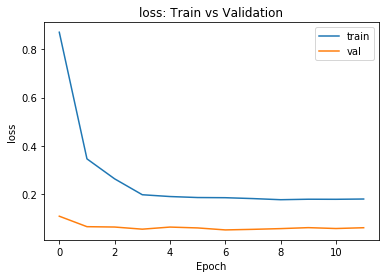

In [95]:
plot_graph(t_record, v_record)

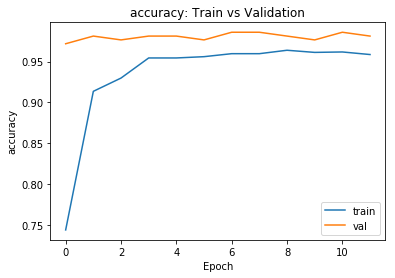

In [96]:
plot_graph(t_record, v_record, gtype='accuracy')

In [113]:
#visualize_model(model_freeze)

In [110]:
def visualize_test_result(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(datasets_loader['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(reverse_mapping[int(preds[j])]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

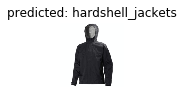

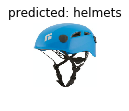

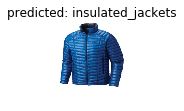

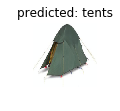

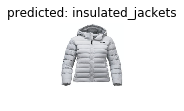

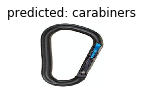

In [111]:
visualize_test_result(model_freeze)

In [37]:
torch.save(model_freeze, 'model_freeze.pth')

# Task 5 

In [5]:
model_freeze=torch.load('model_freeze.pth')
model_freeze.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [27]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#imsize = 256
#loader = transforms.Compose([transforms.Scale(imsize), transforms.ToTensor()])
from torch.autograd import Variable

loader = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def image_loader(image_name):
    """load image, returns cuda tensor"""
    image = Image.open(image_name)
    image = loader(image).float()
    image = image.to(device)
    image = Variable(image, requires_grad=True)
    image = image.unsqueeze(0)
    return image

image = image_loader('1.jpg')

In [8]:
import time
for _ in range(5):
    try:
        result=model_freeze(image)
        print('Successful!')
        break
    except:
        print('Still out of Memory!')
        time.sleep(5)
        
    print('Done!')
        

Successful!


In [28]:
result=model_freeze(image)

In [38]:
classes

['axes',
 'rope',
 'harnesses',
 'gloves',
 'crampons',
 'hardshell_jackets',
 'insulated_jackets',
 'boots',
 'tents',
 'carabiners',
 'helmets',
 'pulleys']

In [36]:
_, predicted = torch.max(result, 1)
classes = list(reverse_mapping.values())
print(classes[(int(predicted))])

carabiners


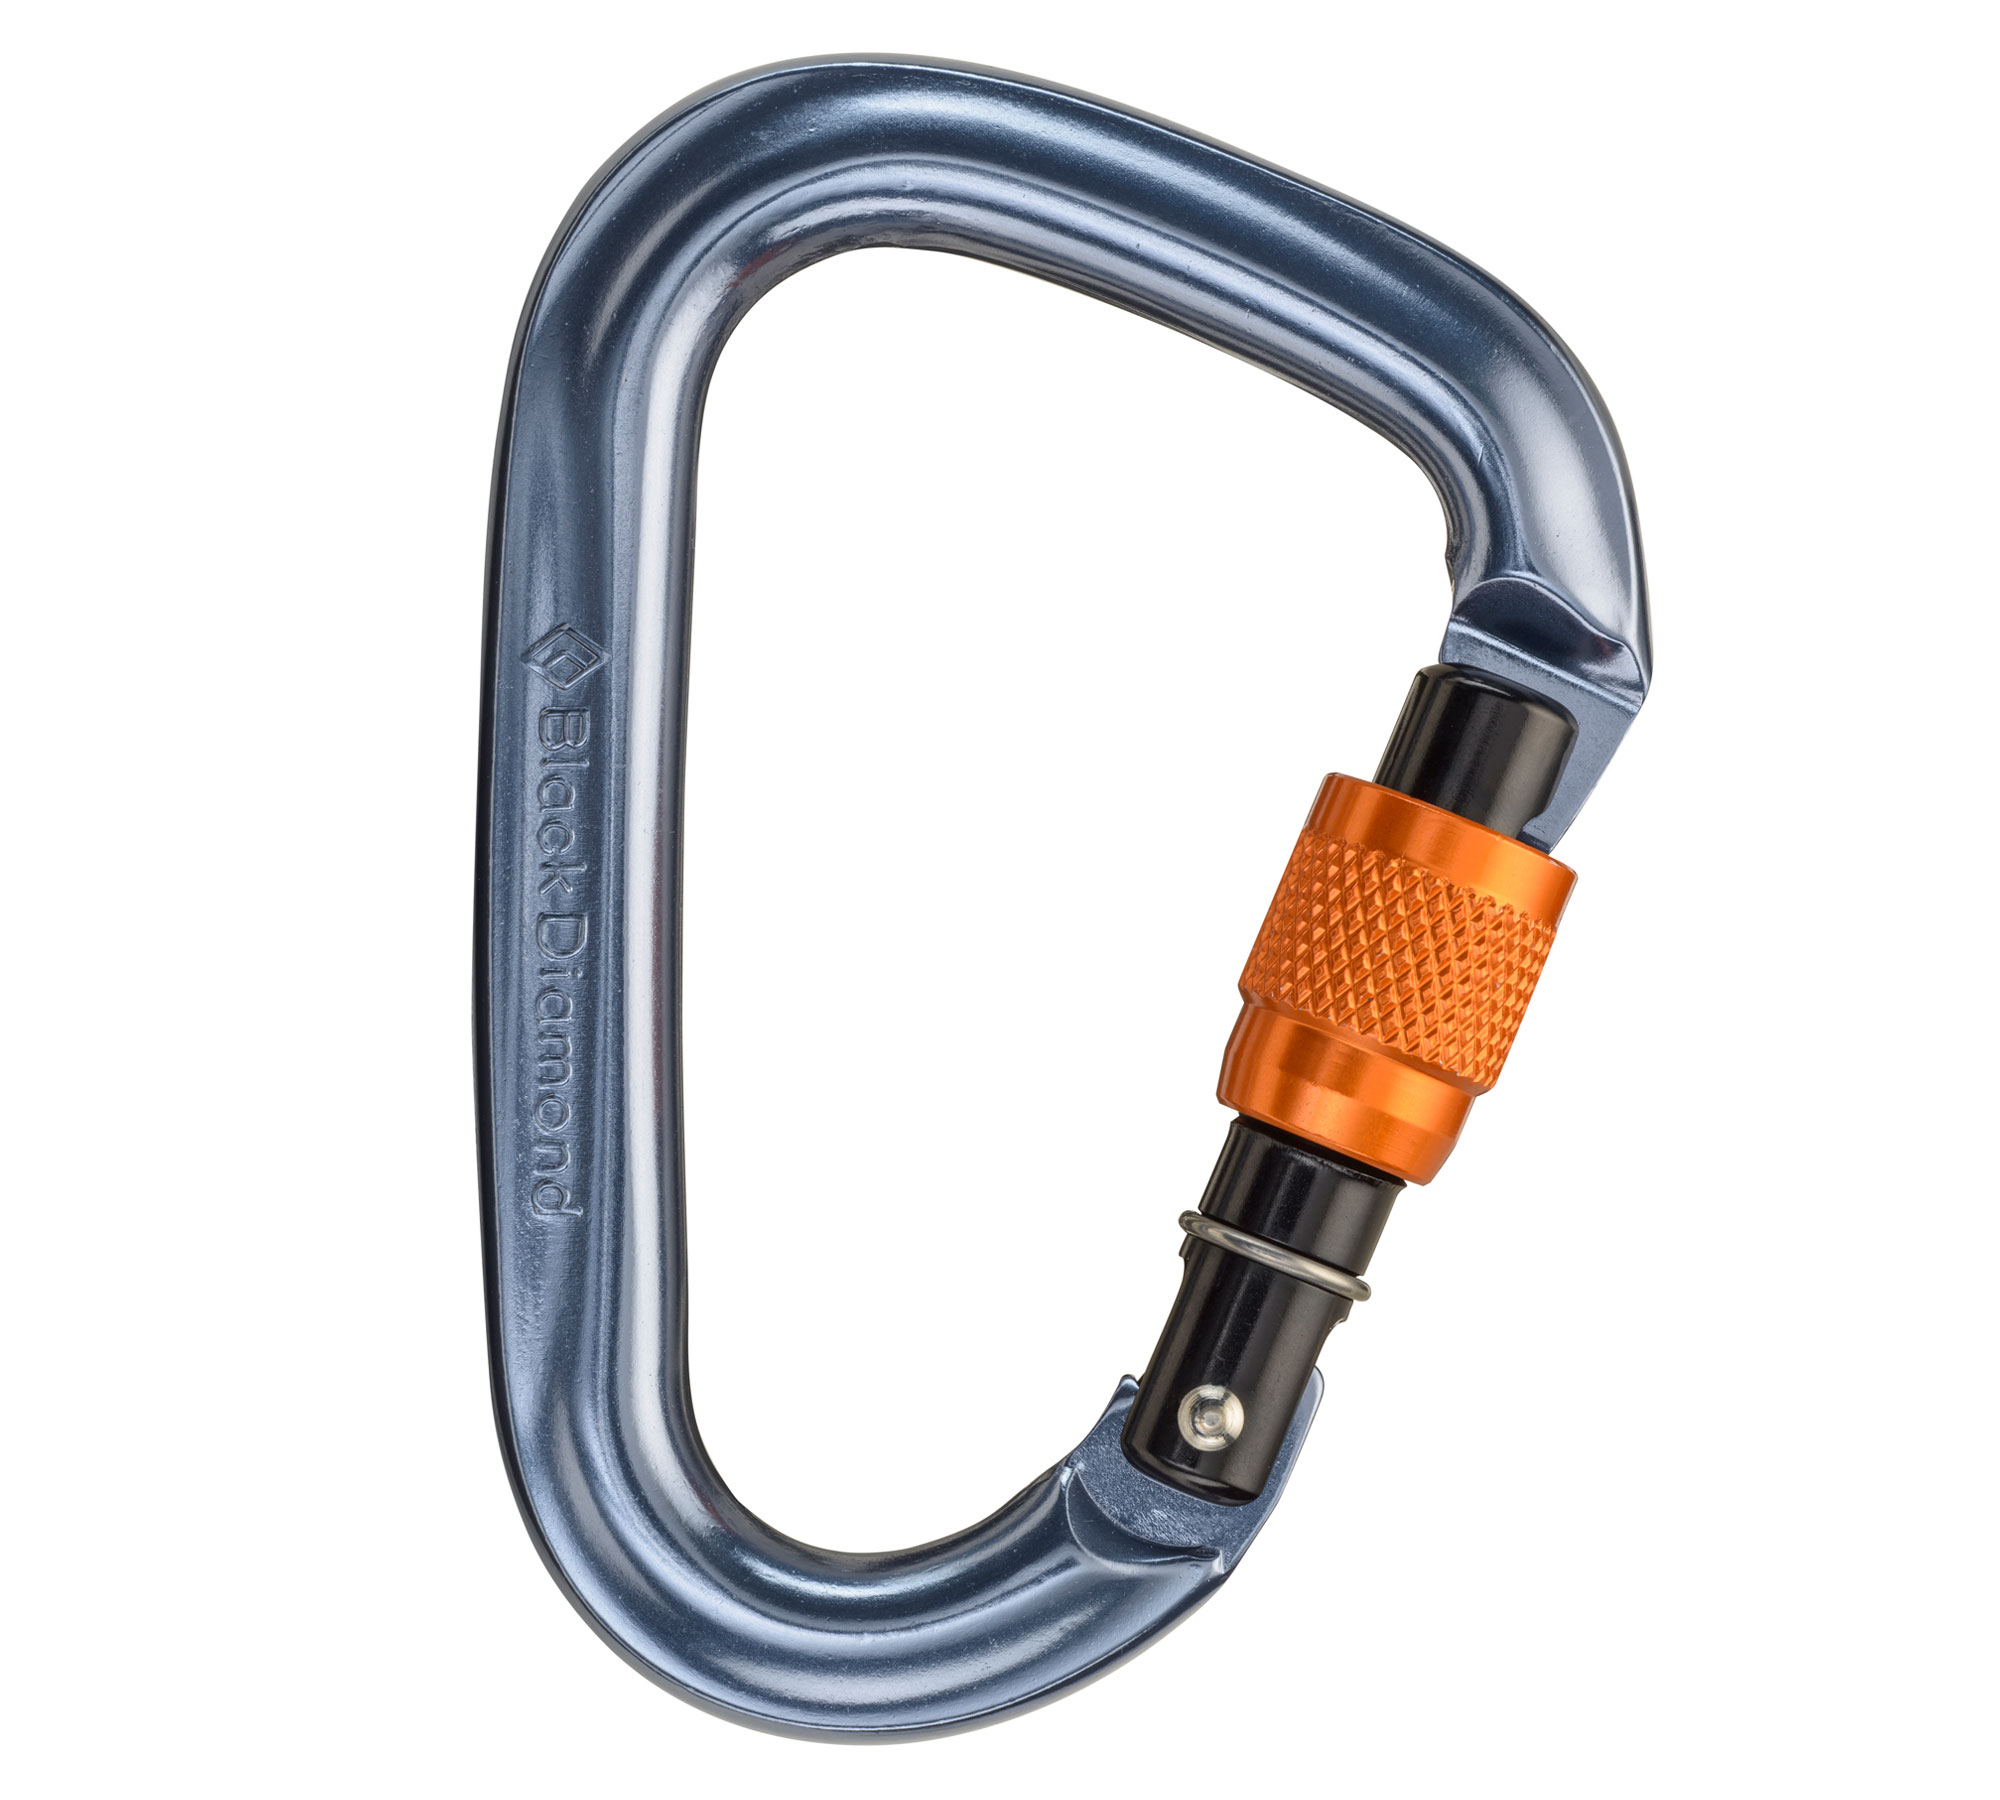

In [55]:
Image.open('1.jpg')

In [ ]:
single_loaded_img = single_loaded_img.to(device)
single_loaded_img = Variable(single_loaded_img)
out_predict = model(single_loaded_img)

In [39]:
import os
os.mkdir('script.py')

In [3]:
!pip install conda --upgrade 

    100% |████████████████████████████████| 307kB 2.7MB/s eta 0:00:01
    100% |████████████████████████████████| 71kB 35.6MB/s ta 0:00:01
  Running setup.py bdist_wheel for conda ... done
  Stored in directory: /home/openhackteam9/.cache/pip/wheels/a3/50/79/302742d53e2231ec545cb3791abfdd24de234021ed8e0588a0
  Running setup.py bdist_wheel for pycosat ... done
  Stored in directory: /home/openhackteam9/.cache/pip/wheels/c4/67/ff/5570304e45814eccef48a3c69c3af25d0456ed3a34eddbbe38
Successfully built conda pycosat


In [5]:
! conda env export > 'environment.yml'

ERROR: The install method you used for conda--probably either `pip install conda`
or `easy_install conda`--is not compatible with using conda as an application.
If your intention is to install conda as a standalone application, currently
supported install methods include the Anaconda installer and the miniconda
installer.  You can download the miniconda installer from
https://conda.io/miniconda.html.



In [11]:
from __future__ import print_function, division

#general operations
import time
import os
import copy

#for openning images via an URL
from PIL import Image
import requests

#data processing
import pandas as pd
import numpy as np

#data visualisation
import matplotlib.pyplot as plt

#ML tools
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data.dataset import Dataset
import torchvision
from torchvision import models, transforms

NameError: name '_C' is not defined

In [18]:
from azureml.core.conda_dependencies import CondaDependencies

myenv = CondaDependencies()
myenv.add_pip_package("pynacl==1.2.1")
myenv.add_pip_package("torch")
myenv.add_pip_package("torchvision")
myenv.add_pip_package("requests")
myenv.add_pip_package("Pillow")

with open("myenv2.yml","w") as f:
    f.write(myenv.serialize_to_string())

In [19]:
with open("myenv2.yml","r") as f:
    print(f.read())

# Conda environment specification. The dependencies defined in this file will
# be automatically provisioned for runs with userManagedDependencies=False.

# Details about the Conda environment file format:
# https://conda.io/docs/user-guide/tasks/manage-environments.html#create-env-file-manually

name: project_environment
dependencies:
  # The python interpreter version.
  # Currently Azure ML only supports 3.5.2 and later.
- python=3.6.2

- pip:
    # Required packages for AzureML execution, history, and data preparation.
  - azureml-defaults
  - torch
  - torchvision
  - requests
  - io
  - Pillow

